### College Scorecard Binary Classification Model 

**Using the following features:**
- 25th - 75th Percentile of SAT & ACT Scores of Accepted Students
- Admission Rate 
- % of Students granted a Federal Loan
- % of studented granted a Pell Grant Loan
- Student body size 
- Number of available higher degrees or certificates offered
- Median debt per graduated student
- Tuition price (high, avg, low)
- Total cost including housing/ books/ required meal plans

**Predict mean salary for students after 10 years past program completion**
- 0: Up to 60K
- 1: 60K & over

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#### Upload Data

In [4]:
school_scores = pd.read_csv('School_Scores')

#### Correlation Heatmap

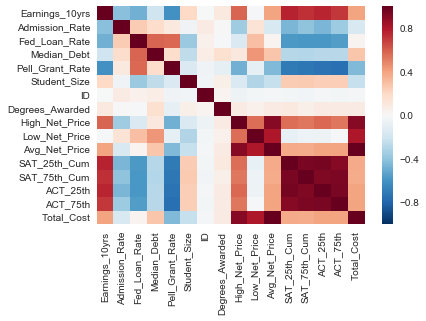

In [5]:
sns.heatmap(school_scores.corr())

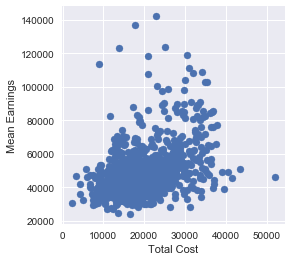

In [6]:
fig, ax = plt.subplots(figsize=[4,4])
ax.scatter(school_scores['Total_Cost'], school_scores['Earnings_10yrs'])
plt.xlabel('Total Cost')
plt.ylabel('Mean Earnings')

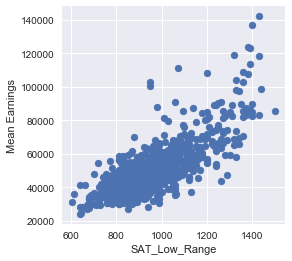

In [7]:
fig, ax = plt.subplots(figsize=[4,4])
ax.scatter(school_scores['SAT_25th_Cum'], school_scores['Earnings_10yrs'])
plt.xlabel('SAT_Low_Range')
plt.ylabel('Mean Earnings')

### Classification Modeling 

In [8]:
school_scores['Target'] = school_scores['Earnings_10yrs'].map(lambda x: 0 if x < 60000 else 1)

In [9]:
school_scores['Target'].value_counts()

0    904
1    148
Name: Target, dtype: int64

In [10]:
correlation = (school_scores.corr()['Target'].apply(lambda x: abs(x)).sort_values(ascending=False))

In [11]:
corr_df = pd.DataFrame()
corr_df['Correlations'] = correlation
corr_df['Feature'] =correlation.index
corr_df.drop(['Earnings_10yrs', 'ID', 'Target'], inplace= True)

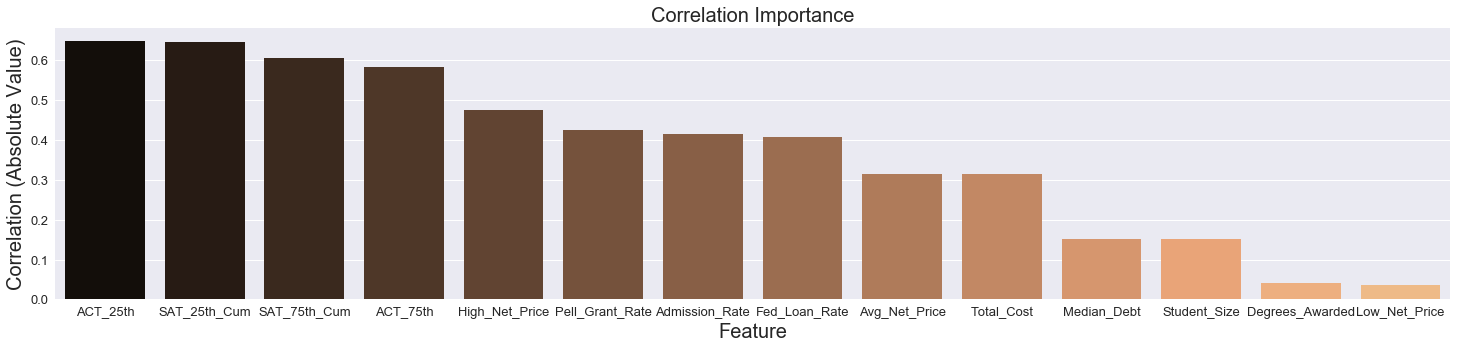

In [12]:
plt.figure(figsize=(25, 5))
sns.barplot('Feature', 'Correlations', data= corr_df, palette='copper')
plt.title('Correlation Importance', size= 20)
plt.xlabel('Feature', size= 20)
plt.ylabel('Correlation (Absolute Value)', size= 20)
plt.tick_params(labelsize=13)
plt.show()

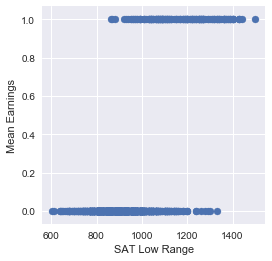

In [13]:
fig, ax = plt.subplots(figsize=[4,4])
ax.scatter(school_scores['SAT_25th_Cum'], school_scores['Target'])
plt.xlabel('SAT Low Range')
plt.ylabel('Mean Earnings')

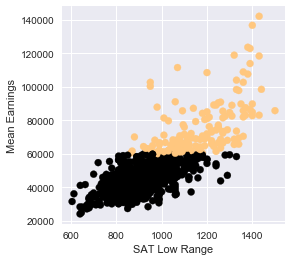

In [14]:
fig, ax = plt.subplots(figsize=[4,4])
plt.scatter(school_scores['SAT_25th_Cum'], school_scores['Earnings_10yrs'], c=school_scores['Target'], cmap='copper')
plt.xlabel('SAT Low Range')
plt.ylabel('Mean Earnings')

In [15]:
plotter = school_scores[[ 'Admission_Rate', 'Fed_Loan_Rate', 'Median_Debt',
       'Pell_Grant_Rate', 'Student_Size', 'Degrees_Awarded',
        'High_Net_Price', 'Low_Net_Price',
       'SAT_25th_Cum', 'SAT_75th_Cum', 'Total_Cost',
       'Target']]

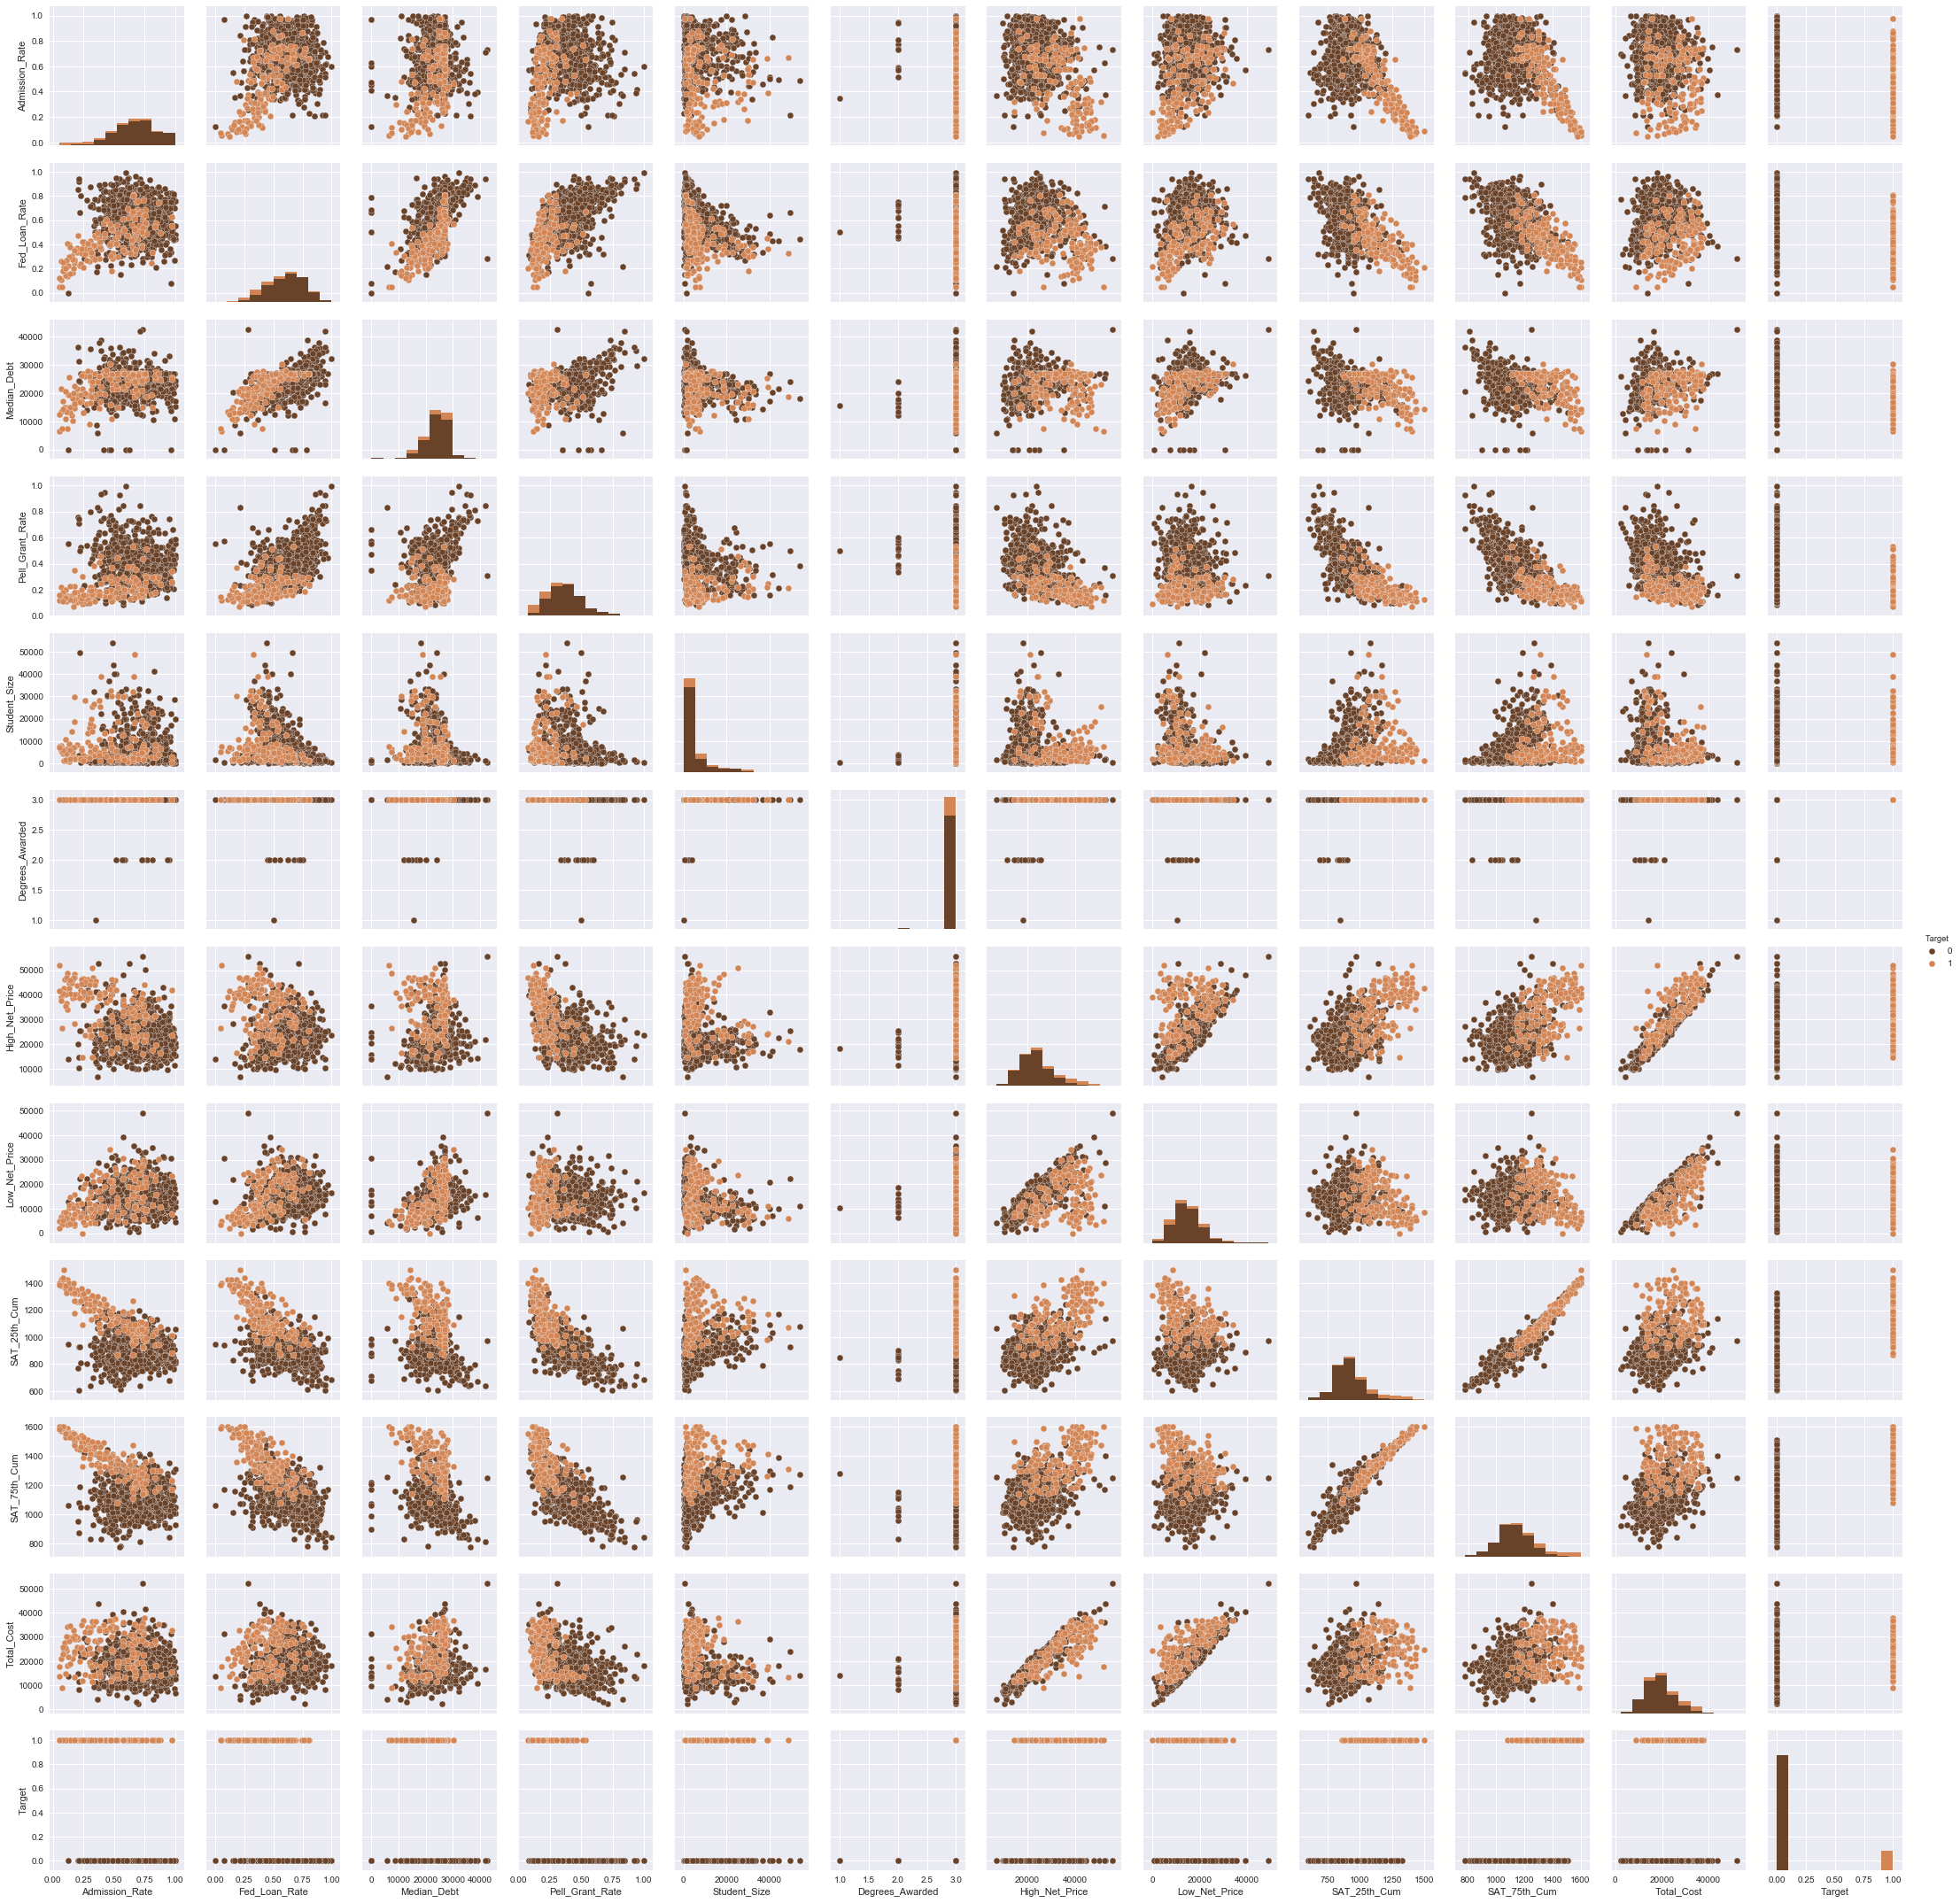

In [16]:
sns.pairplot(plotter, hue= 'Target', palette='copper')

### Classification Modeling 

#### Data Train/ Test Split

In [17]:
X = school_scores[['Admission_Rate', 'Fed_Loan_Rate', 'Median_Debt',
                   'Pell_Grant_Rate', 'Student_Size', 'Degrees_Awarded',
                   'High_Net_Price', 'Low_Net_Price', 'Avg_Net_Price',
                   'SAT_25th_Cum', 'SAT_75th_Cum', 'ACT_25th', 'ACT_75th', 'Total_Cost']].copy()
y = school_scores['Target'].copy()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [19]:
ss= StandardScaler()
Xs_train= ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

#### Baseline Calculation

In [20]:
baseline_acc = round((school_scores['Target'].value_counts().max()) / (y.shape[0]), 2)
baseline_acc

0.85999999999999999

#### KNN Model

In [21]:
knn = KNeighborsClassifier(n_neighbors= 13)
knn.fit(Xs_train, y_train)

y_pred_knn = knn.predict(Xs_test)
print(metrics.accuracy_score(y_test, y_pred_knn))

0.922413793103


In [22]:
# KNN cross-val score
scores_knn = cross_val_score(knn, Xs_train, y_train, cv=5)
print(scores_knn)
print(np.mean(scores_knn))

[ 0.92907801  0.89361702  0.89361702  0.93617021  0.93571429]
0.917639311044


In [23]:
# KNN Confusion matrix
from sklearn.metrics import confusion_matrix
predicted = knn.predict(Xs_test)
confusion_matrix(y_test, predicted)

array([[289,  11],
       [ 16,  32]])

### Ensemble Model

In [24]:
# Ensemble Model
clf = DecisionTreeClassifier(max_depth=3)
bag_clf = BaggingClassifier(clf)

bag_clf.fit(Xs_train, y_train)
y_pred_bag = bag_clf.predict(Xs_test)
print(metrics.accuracy_score(y_test, y_pred_bag))

0.916666666667


In [25]:
# Ensemble cross-val score
scores_bag = cross_val_score(bag_clf, Xs_train, y_train, cv=5)
print(scores_bag)
print(np.mean(scores_bag))

[ 0.94326241  0.90070922  0.88652482  0.92198582  0.91428571]
0.913353596758


In [26]:
# Ensemble Confusion Matrix
predicted_bag = bag_clf.predict(Xs_test)
confusion_matrix(y_test, predicted_bag)

array([[293,   7],
       [ 22,  26]])

## Adding More Features

Not satisfied with the accuracy score of previous model.  
I am importing new features on the percentage of races that make up the student demographics

In [27]:
race = pd.read_csv('Race_Final')

In [28]:
race = race.drop('Unnamed: 0', axis=1)

In [29]:
race = race.set_index('id')
school_scores2 = school_scores.set_index('ID')

In [30]:
new_data = pd.concat([school_scores2, race], axis=1, join='inner')

In [31]:
school_scores2.shape

(1052, 17)

In [32]:
new_data.shape

(1039, 27)

In [33]:
new_data.isnull().sum()

Earnings_10yrs        0
Admission_Rate        0
Fed_Loan_Rate         0
Median_Debt           0
Pell_Grant_Rate       0
Student_Size          0
Degrees_Awarded       0
School_Name           0
High_Net_Price        0
Low_Net_Price         0
Avg_Net_Price         0
SAT_25th_Cum          0
SAT_75th_Cum          0
ACT_25th              0
ACT_75th              0
Total_Cost            0
Target                0
aian                  0
asian                 0
black                 0
hispanic              0
nhpi                  0
non_resident_alien    0
two_or_more           0
unknown               0
white                 0
school.name           0
dtype: int64

In [36]:
new_data.sort_values(by='Earnings_10yrs', ascending=False).head(10)

,Earnings_10yrs,Admission_Rate,Fed_Loan_Rate,Median_Debt,Pell_Grant_Rate,Student_Size,Degrees_Awarded,School_Name,High_Net_Price,Low_Net_Price,...,aian,asian,black,hispanic,nhpi,non_resident_alien,two_or_more,unknown,white,school.name
166683,142100.0,0.0830,0.1833,17316.0,0.1786,4474.0,3,Massachusetts Institute of Technology,41018.0,6391.0,...,0.0009,0.2501,0.0568,0.1524,0.0002,0.0975,0.0595,0.0170,0.3657,Massachusetts Institute of Technology
243744,122900.0,0.0504,0.1211,12475.0,0.1573,6994.0,3,Stanford University,41703.0,1932.0,...,0.0102,0.2047,0.0608,0.1533,0.0031,0.0875,0.1037,0.0030,0.3737,Stanford University
188526,111500.0,0.6587,0.8090,26848.0,0.2408,1001.0,3,Albany College of Pharmacy and Health Sciences,33361.0,24766.0,...,0.0020,0.1429,0.0360,0.0460,0.0000,0.0629,0.0120,0.0460,0.6523,Albany College of Pharmacy and Health Sciences
164580,108500.0,0.2630,0.3626,26000.0,0.1628,2141.0,3,Babson College,45142.0,20005.0,...,0.0014,0.1238,0.0486,0.0976,0.0009,0.2606,0.0248,0.0584,0.3839,Babson College
166656,102700.0,0.8656,0.7442,27000.0,0.2965,3877.0,3,MCPHS University,38273.0,30265.0,...,0.0026,0.2388,0.0655,0.0490,0.0010,0.1339,0.0090,0.0833,0.4168,MCPHS University
211440,102700.0,0.2372,0.3645,26250.0,0.1298,5964.0,3,Carnegie Mellon University,44518.0,23425.0,...,0.0010,0.2835,0.0468,0.0810,0.0002,0.1784,0.0426,0.0495,0.3171,Carnegie Mellon University
161299,100300.0,0.6515,0.8006,27000.0,0.2937,991.0,3,Maine Maritime Academy,25301.0,18740.0,...,0.0050,0.0111,0.0101,0.0131,0.0040,0.0000,0.0000,0.0444,0.9122,Maine Maritime Academy
144050,98500.0,0.0838,0.2543,14500.0,0.1114,5869.0,3,University of Chicago,40618.0,5263.0,...,0.0024,0.1741,0.0504,0.0849,0.0009,0.1084,0.0348,0.0992,0.4451,University of Chicago
190415,98400.0,0.1507,0.3032,12000.0,0.1547,14226.0,3,Cornell University,44931.0,11579.0,...,0.0037,0.1809,0.0606,0.1213,0.0009,0.0967,0.0446,0.0819,0.4093,Cornell University
112260,97800.0,0.1096,0.1514,14967.5,0.1153,1325.0,3,Claremont McKenna College,36704.0,7701.0,...,0.0008,0.1026,0.0430,0.1358,0.0015,0.1668,0.0657,0.0611,0.4226,Claremont McKenna College


In [37]:
X_new = new_data[[ 'Admission_Rate', 'Fed_Loan_Rate', 'Median_Debt',
       'Pell_Grant_Rate', 'Student_Size', 'Degrees_Awarded',
       'High_Net_Price', 'Low_Net_Price', 'Avg_Net_Price', 'SAT_25th_Cum',
       'SAT_75th_Cum', 'ACT_25th', 'ACT_75th', 'Total_Cost', 'aian',
       'asian', 'black', 'hispanic', 'nhpi', 'non_resident_alien',
       'two_or_more', 'unknown', 'white']]
y_new = new_data['Target']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.25)

In [62]:
ss= StandardScaler()
Xs_train= ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

##### Ensemble Model & Cross-Val Score

In [63]:
clf = DecisionTreeClassifier(max_depth=5)
bag_clf = BaggingClassifier(clf)

bag_clf.fit(Xs_train, y_train)
y_pred_bag = bag_clf.predict(Xs_test)
print(metrics.accuracy_score(y_test, y_pred_bag))

0.911538461538


In [64]:
scores_bag = cross_val_score(bag_clf, Xs_train, y_train, cv=5)
print(scores_bag)
print(np.mean(scores_bag))

[ 0.91025641  0.91666667  0.90384615  0.92307692  0.91612903]
0.913995037221


##### KNN Model & Cross-Val Score

In [65]:
knn = KNeighborsClassifier(n_neighbors= 14)
knn.fit(Xs_train, y_train)

y_pred_knn = knn.predict(Xs_test)
print(metrics.accuracy_score(y_test, y_pred_knn))

0.911538461538


In [66]:
scores_knn = cross_val_score(knn, Xs_train, y_train, cv=5)
print(scores_knn)
print(np.mean(scores_knn))

[ 0.91025641  0.92948718  0.8974359   0.91666667  0.91612903]
0.913995037221


##### KNN Grid Search 

In [67]:
knn_dict = {
    'n_neighbors': [10, 12, 14, 16],
    'p': [1, 2],
    'weights': ['uniform', 'distance']}

In [68]:
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, knn_dict, verbose=2, n_jobs=-1)
grid_search.fit(Xs_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] n_neighbors=10, p=1, weights=uniform ............................
[CV] n_neighbors=10, p=1, weights=uniform ............................
[CV] n_neighbors=10, p=1, weights=uniform ............................
[CV] n_neighbors=10, p=1, weights=distance ...........................
[CV] ............. n_neighbors=10, p=1, weights=uniform, total=   0.0s
[CV] n_neighbors=10, p=1, weights=distance ...........................
[CV] ............. n_neighbors=10, p=1, weights=uniform, total=   0.0s
[CV] ............ n_neighbors=10, p=1, weights=distance, total=   0.0s
[CV] ............. n_neighbors=10, p=1, weights=uniform, total=   0.0s
[CV] n_neighbors=10, p=1, weights=distance ...........................
[CV] n_neighbors=10, p=2, weights=uniform ............................
[CV] n_neighbors=10, p=2, weights=uniform ............................
[CV] ............ n_neighbors=10, p=1, weights=distance, total=   0.0s
[CV] ...........

[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [10, 12, 14, 16], 'p': [1, 2], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [69]:
grid_search.best_score_

0.91912708600770221

In [70]:
grid_search.best_params_

{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}

In [71]:
y_test_pred = grid_search.best_estimator_.predict(Xs_test)

In [72]:
print(metrics.accuracy_score(y_test, y_test_pred))

0.915384615385


##### Gradient Boost Model

In [73]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [74]:
gbc = GradientBoostingClassifier()
gbc_params = {
    'n_estimators' : [75, 100, 125],
    'max_depth' : range(2,5),
    'max_features' : ['auto', 'log2', None]
}
gbc_model = GridSearchCV(gbc, param_grid= gbc_params)
gbc_model.fit(Xs_train, y_train)
print('Best Score: ', gbc_model.best_score_)
print('Best Params: ', gbc_model.best_params_)
print('Test Score: ', gbc_model.score(Xs_test, y_test))

Best Score:  0.920410783055
Best Params:  {'max_depth': 4, 'max_features': 'log2', 'n_estimators': 125}
Test Score:  0.938461538462


In [75]:
predicted = gbc_model.predict(Xs_test)

In [76]:
predicted_p = gbc_model.predict_proba(Xs_test)

In [77]:
conmat = np.array(confusion_matrix(y_test, predicted))
confusion = pd.DataFrame(conmat, index=['Under_60K', 'Over_60K'],
                        columns = ['Predicted_Under_60K', 'Predicted_Over_60K'])
confusion

,Predicted_Under_60K,Predicted_Over_60K
Under_60K,213,7
Over_60K,9,31


#### Findings:

Typically a school with a low acceptance rate with students that score higher on admission tests have higher tuition.  Those schools tend to have students who earn higher salaries upon graduation.  

However, the model is not perfect and tuition price is not strongly correlated to mean earnings.  There are many schools that are easier to get into and at a discounted tuition that produce the same success in their students. 

I'd like to explore this further to target schools that are a good fit for high achieving, low income students.

It's also a problem that 86% of schools (in the data) have a mean earnings of under 60K.  This mean is 10 years after graduation.  The middle class dilemma is a real issue. 

##### Model can predict if the mean earnings of students who attend a certain school 10 years after graduation is above 60K with almost 94.00% accuracy

Next Steps:
- You can use this data for many more applications like deciding what tuition should be, identifying schools that are low cost with high earnings potential for low-income students, etc  See my search engine notebook for real-world application.
- Add more features to dataset.  I'd like to add information on what category of programs are offered.  I believe schools with a high percentage of STEM (science, technology, engineering, math) classes will positively correlate with earnings potential. In addition to profressional specialty programs (aviation, law, psychology) will also positively correlate with earnings potential) 